In [1]:
import os, sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm  # progress meter

import matplotlib.pyplot as plt
%matplotlib inline

os.chdir(os.environ.get("PWD"))  # change working directory to project directory

Duplicate key in file '/Users/martin/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


### Logistic regression

In [2]:
diabetes = pd.read_csv('data/diabetes/diabetes_v3.csv')

In [3]:
features = [
    'cholesterol', 
    'gluc', 
    'active',      
    'gender',
    'age',
    'height', 
    'weight', 
    'pressure_high',
    'pressure_low' 
]

Let's normalize the data before training the model. We normalize the test data with the feature min and feature max from the training data.

In [4]:
# Train data
X_train = diabetes[diabetes["ind"].eq("train")][features]
feature_min, feature_max = X_train.min(), X_train.max()

# Test data
X_test = diabetes[diabetes["ind"].eq("test")][features]

# Min-Max-Normalization
X_train = (X_train - feature_min)/(feature_max - feature_min)
X_test = (X_test - feature_min)/(feature_max - feature_min)

# Labels
y_train = diabetes[diabetes["ind"].eq("train")]["diabetes"]
y_test = diabetes[diabetes["ind"].eq("test")]["diabetes"]

In [5]:
from sklearn.linear_model import LogisticRegression

# Build the model
logistic_regression = LogisticRegression()
logistic_regression = logistic_regression.fit(X_train, y_train)

# Predict test and train data
accuracy = {}
accuracy["train"] = logistic_regression.score(X_train, y_train)
accuracy["test"] = logistic_regression.score(X_test, y_test)
print(f'Train accuracy: {accuracy["train"]:.4f}')
print(f'Test accuracy: {accuracy["test"]:.4f}')

# Predict test data
pred_diabetes_prob = logistic_regression.predict_proba(X_test)[:,1]
y_pred = pred_diabetes_prob > 0.5

Train accuracy: 0.9557
Test accuracy: 0.9545


In [6]:
positive_pred = y_pred == True
negative_pred = y_pred == False

correct_pred = (y_pred == y_test)
incorrect_pred = (y_pred != y_test)

### Precision
The precision is a metric given by the ratio of correct positive predictions out of all positive predictions. Therefore, it measures the correctness of positive predictions. As incorrect positive predictions are False Alarm, Type I, or False Positive Errors, precision is a measure for Type I Errors, i.e. overestimation.

How do Precision and Specificity compare wrt. being a measure of Type I Errors?

$$
\text{Precision} = 
\frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}
$$


In [7]:
true_positive = positive_pred & correct_pred
false_positive = positive_pred & incorrect_pred
precision = true_positive.sum()/(true_positive.sum() + false_positive.sum())
print(f'True positives: {true_positive.sum()}')
print(f'False positives: {false_positive.sum()}')
print(f'{true_positive.sum()} of {true_positive.sum() + false_positive.sum()} positive predictions correct')
print(f'Precision {precision:.4f}')

True positives: 2161
False positives: 141
2161 of 2302 positive predictions correct
Precision 0.9387


### Recall (Sensitivity)

The recall is a metric given by the ratio of correct positive predictions out of those who have the condition ($y=1$). It measures how well a predictor can detect a condition and can be interpreted as the probability of detection.

$$
\text{Recall} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}
$$

In [8]:
false_negative = negative_pred & incorrect_pred
recall = true_positive.sum() / (true_positive.sum() + false_negative.sum())
print(f'True positives: {true_positive.sum()} (y=1)')
print(f'False negatives: {false_negative.sum()} (y=1)')
print(f'{true_positive.sum()} of {true_positive.sum() + false_negative.sum()} positive conditions predicted')
print(f'Recall: {recall:.4f}')

True positives: 2161 (y=1)
False negatives: 299 (y=1)
2161 of 2460 positive conditions predicted
Recall: 0.8785


### Specificity

The specificity is a metric given by the ratio of correct negative predictions out of those who dont have the condition (y=0). It measures how well a predictor can reject those who dont have the condition.
$$
\text{Sensitivity} = \frac{\text{True Negative}}{\text{True Negative} + \text{False Positive}}
$$

In [9]:
true_negative = negative_pred & correct_pred
specificity = true_negative.sum() / (true_negative.sum() + false_positive.sum())
print(f'True negatives: {true_negative.sum()}')
print(f'False positives: {false_positive.sum()}')
print(f'{true_negative.sum()} of {true_negative.sum() + false_positive.sum()} negative conditions predicted')
print(f'Specificity: {specificity:.4f}')

True negatives: 7079
False positives: 141
7079 of 7220 negative conditions predicted
Specificity: 0.9805


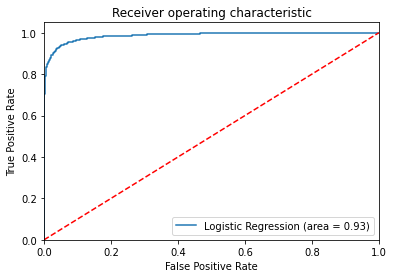

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
roc_auc_scores = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, pred_diabetes_prob)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_scores)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('results/outputs/logistic_regression_roc')
plt.show()